In [1]:
# Import library
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import random
import matplotlib.pyplot as plt

# Disable progress bar output
tf.keras.utils.disable_interactive_logging()

In [2]:
class DoubleDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999  # Slower decay
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = keras.Sequential([
            keras.layers.Dense(24, input_dim=self.state_size, activation='relu'),
            keras.layers.Dense(24, activation='relu'),
            keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        states = np.array([i[0][0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3][0] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma * (np.amax(self.target_model.predict(next_states, verbose=0), axis=1)) * (1 - dones)
        targets_full = self.model.predict(states, verbose=0)
        
        targets_full[[np.arange(batch_size)], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0, batch_size=batch_size)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DoubleDQNAgent(state_size, action_size)
batch_size = 32

n_episodes = 1000
scores = []
update_target_frequency = 10

for e in range(n_episodes):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    steps = 0
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = np.reshape(next_state, [1, state_size])
        
        agent.remember(state, action, reward, next_state, done)
        
        state = next_state
        steps += 1
        
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    
    scores.append(steps)
    
    if (e + 1) % update_target_frequency == 0:
        agent.update_target_model()
    
    if e % 5 == 0:  # Print every 5 episodes
        print(f"episode: {e}/{n_episodes}, score: {steps}, epsilon: {agent.epsilon:.2f}")

    # Early stopping condition
    if len(scores) > 100 and np.mean(scores[-100:]) > 195:
        print(f"Solved in {e} episodes!")
        break

# Plot training results
plt.figure(figsize=(10, 5))
plt.plot(scores)
plt.title('Double DQN Training on CartPole')
plt.xlabel('Episode')
plt.ylabel('Score (Steps)')
plt.show()


In [5]:
# Save the trained model
agent.save("cartpole_dqn.weights.h5")

Completed 5 test episodes
Completed 10 test episodes
Completed 15 test episodes
Completed 20 test episodes
Completed 25 test episodes
Completed 30 test episodes
Completed 35 test episodes
Completed 40 test episodes
Completed 45 test episodes
Completed 50 test episodes
Completed 55 test episodes
Completed 60 test episodes
Completed 65 test episodes
Completed 70 test episodes
Completed 75 test episodes
Completed 80 test episodes
Completed 85 test episodes
Completed 90 test episodes
Completed 95 test episodes
Completed 100 test episodes

Test Results over 100 episodes:
Average Score: 298.07
Median Score: 284.00
Min Score: 195
Max Score: 499
Scores above 195: 99 out of 100


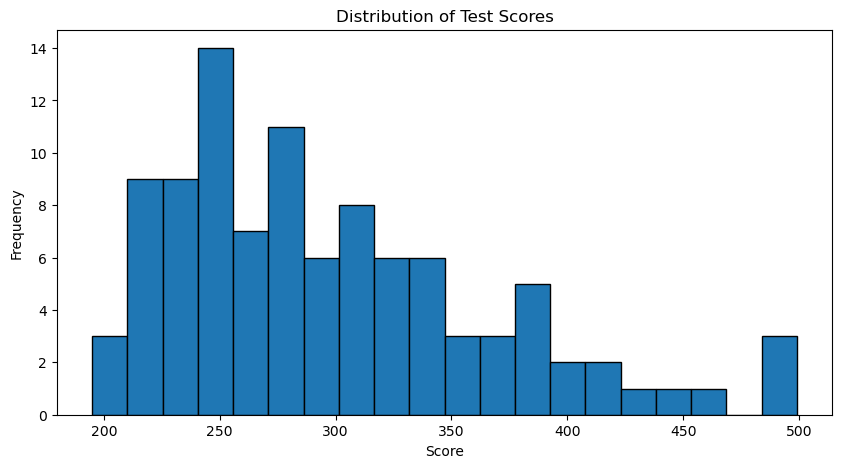

In [6]:
test_episodes = 100
test_scores = []

for e in range(test_episodes):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(500):
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = np.reshape(next_state, [1, state_size])
        if done:
            test_scores.append(time)
            break
    
    if (e + 1) % 5 == 0:
        print(f"Completed {e + 1} test episodes")

print(f"\nTest Results over {test_episodes} episodes:")
print(f"Average Score: {np.mean(test_scores):.2f}")
print(f"Median Score: {np.median(test_scores):.2f}")
print(f"Min Score: {np.min(test_scores)}")
print(f"Max Score: {np.max(test_scores)}")
print(f"Scores above 195: {sum(score > 195 for score in test_scores)} out of {test_episodes}")

plt.figure(figsize=(10, 5))
plt.hist(test_scores, bins=20, edgecolor='black')
plt.title('Distribution of Test Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

env.close()